*Nos données datent de 1980, cependant l'accès aux données a évolué avec le temps et il se peut que certaines données soient manquantes. Néanmoins, les données sur les catastrophes naturelles restent assez fiables*


# Import des librairies utilisées lors de l'analyse et traitement des données


In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Pré-traitement des données

Récupération des données du CSV: "Country Mapping.csv"

In [99]:
df_countries = pd.read_csv('Country Mapping.csv', delimiter=';')
df_countries = df_countries.rename(columns={'alpha-3': 'ISO3', 'name': 'Country', 'region': 'Region'}).drop(columns=['alpha-2', 'sub-region'])
df_countries.head() 

,Country,ISO3,Region
0,Afghanistan,AFG,Asia
1,Åland Islands,ALA,Europe
2,Albania,ALB,Europe
3,Algeria,DZA,Africa
4,American Samoa,ASM,Oceania


In [100]:
# Lit le fichier csv et le stocke dans df_disasters
df_disasters = pd.read_csv("Climate Disasters Frequency.csv", delimiter=",")

# Supprime les colonnes inutiles
df_disasters = df_disasters.drop(columns=["ObjectId", "Country", "ISO2", "Unit", "Source", "CTS_Code", "CTS_Name", "CTS_Full_Descriptor"])

# Renomme les colonnes des années qui commencent par "F" en enlevant le "F" préfixe
df_disasters = df_disasters.rename(columns=lambda x: x[1:] if x.startswith("F") else x)
df_disasters = df_disasters.rename(columns={"Indicator": "Disaster"})

# Fusionner les dataframes afin d'obtenir les noms des pays et leur continent grâce à ISO3
df_disasters = df_disasters.merge(df_countries, on="ISO3")

# Renomme les valeurs de Disaster en gardant uniquement le nom de la catastrophe
str_to_remove = "Climate related disasters frequency, Number of Disasters: "
df_disasters["Disaster"] = df_disasters["Disaster"].str.replace(str_to_remove, "")

# Supprime les lignes où Disaster est égal à "TOTAL"
df_disasters = df_disasters[df_disasters["Disaster"] != "TOTAL"]

# Melt le dataframe pour avoir les années dans une colonne
df_disasters = df_disasters.melt(id_vars=["Disaster", "ISO3", "Country", "Region"], var_name="Year", value_name="Occurrences")

# Affiche le haut du dataframe
df_disasters.head()

,Disaster,ISO3,Country,Region,Year,Occurrences
0,Drought,AFG,Afghanistan,Asia,1980,NaN
1,Extreme temperature,AFG,Afghanistan,Asia,1980,NaN
2,Flood,AFG,Afghanistan,Asia,1980,1.0
3,Landslide,AFG,Afghanistan,Asia,1980,NaN
4,Storm,AFG,Afghanistan,Asia,1980,NaN


Nettoyage des données du CSV : "Atmospheric CO2 Concentrations.csv"

In [101]:
# Lit le fichier csv et le stocke dans df_co2
df_co2 = pd.read_csv('Atmospheric CO2 Concentrations.csv', delimiter=',')

# Supprime les lignes où l'unité est en pourcent
df_co2 = df_co2[df_co2['Unit'] != 'Percent']

# Convertit les dates en datetime
df_co2['Date'] = pd.to_datetime(df_co2['Date'], format='%YM%m')

# Extrait l'année de la date et le rajoute dans une colonne "Year"
df_co2['Year'] = df_co2['Date'].dt.year

# Supprime les valeurs pour les années antérieures à 1980
df_co2 = df_co2[df_co2['Year'] >= 1980]

# Groupe les données par année
df_co2 = df_co2.groupby('Year')['Value'].mean().reset_index()
df_co2.head()

,Year,Value
0,1980,338.762500
1,1981,340.119167
2,1982,341.479167
3,1983,343.152500
4,1984,344.868333


Création d'un dictionnaire des noms français des catastrophes étudiées

In [102]:
disasters_translation = {
    "Flood": "Inondation",
    "Drought": "Sécheresse",
    "Extreme temperature": "Température extrême",
    "Wildfire": "Feu de forêt",
    "Storm": "Tempête",
    "Landslide": "Glissement de terrain",
}

## Création d'un dataframe groupant par catastrophe et par année

In [103]:
# Dataframe avec les occurences de catastrophes par année dans le monde
df_disasters_world = df_disasters.groupby(["Disaster", "Year"]).sum("Occurrences").reset_index()
df_disasters_world.tail()

,Disaster,Year,Occurrences
253,Wildfire,2018,10.0
254,Wildfire,2019,14.0
255,Wildfire,2020,9.0
256,Wildfire,2021,19.0
257,Wildfire,2022,15.0


# Graphiques


# Graphique en barres empilées par année


Liste des catastrophes, ordonnée par le nombre de moyen de leur fréquence

In [104]:
# Calculer le total des occurrences par type de catastrophe
mean_per_type = df_disasters_world.groupby('Disaster')['Occurrences'].mean()

# Trier ces totals en ordre décroissant
sorted_types = mean_per_type.sort_values(ascending=False).index

Création du diagramme

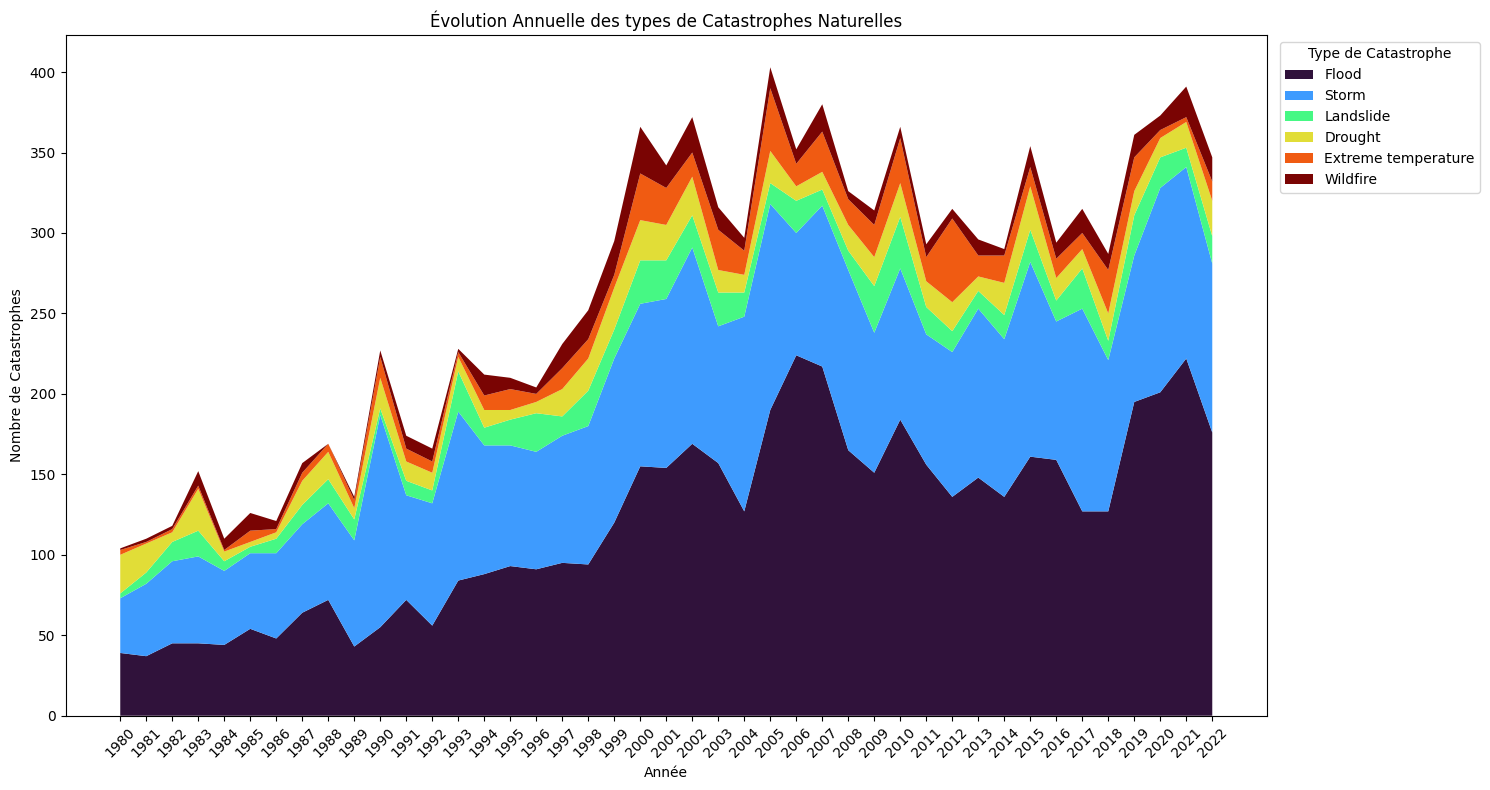

In [105]:
# Créer un tableau croisé pour avoir les années en lignes et les types de catastrophes en colonnes
pivot_disaster_year = df_disasters_world.pivot(index='Year', columns='Disaster', values='Occurrences')

# Réordonner les colonnes selon l'ordre obtenu
pivot_disaster_year = pivot_disaster_year[sorted_types]

# Créer un diagramme empilé
plt.figure(figsize=(15, 8))
plt.stackplot(pivot_disaster_year.index, pivot_disaster_year.T, labels=pivot_disaster_year.columns, colors=plt.cm.turbo(np.linspace(0, 1, len(pivot_disaster_year.columns))))
plt.title('Évolution Annuelle des types de Catastrophes Naturelles')
plt.xlabel('Année')
plt.ylabel('Nombre de Catastrophes')
plt.xticks(rotation=45)
plt.legend(title='Type de Catastrophe', bbox_to_anchor=(1.005, 1), loc='upper left')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Graphique à barres empilées

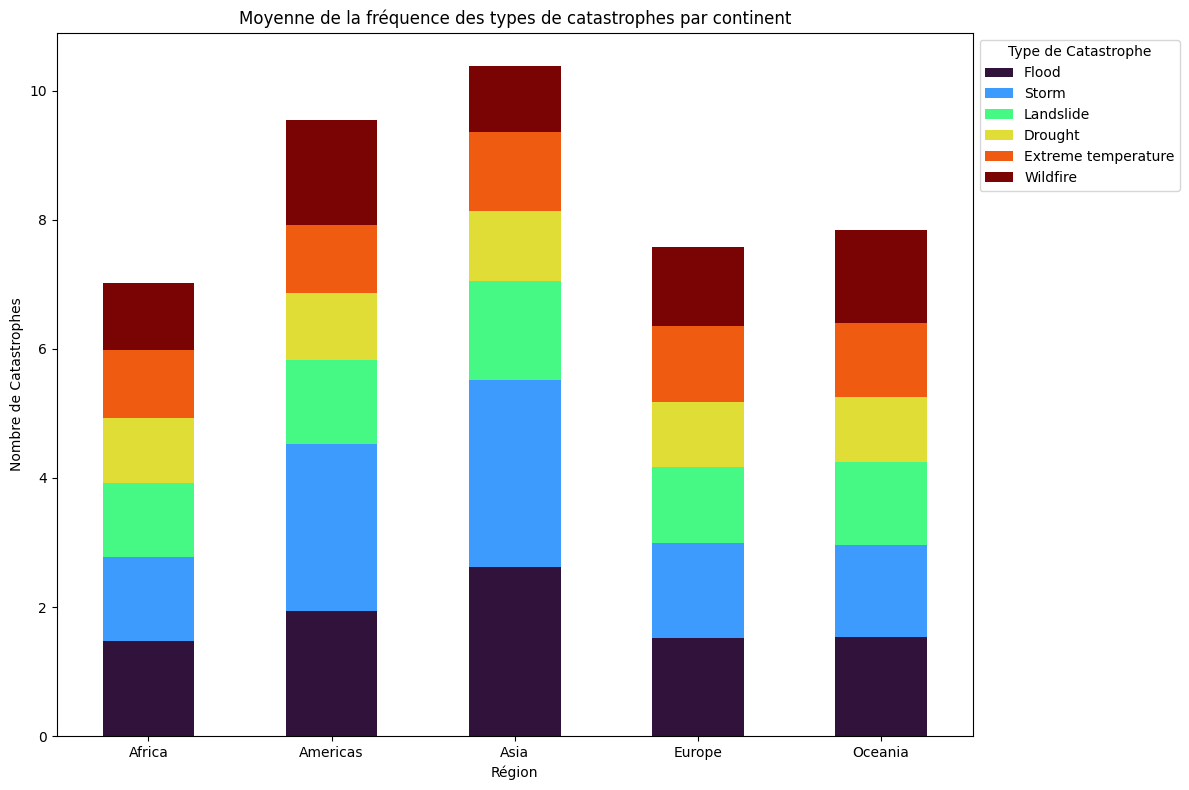

In [106]:
# Regrouper par contient (Region) et type de catastrophe en aggrégant les occurrences par moyenne
grouped_region_disaster = df_disasters.groupby(['Region', 'Disaster']).mean("Occurrences").reset_index()

# Créer un pivot pour avoir les types de catastrophes en colonnes
pivot_region_disaster = grouped_region_disaster.pivot(index='Region', columns='Disaster', values='Occurrences').fillna(0)

# Réordonner les colonnes selon l'ordre obtenu
pivot_region_disaster = pivot_region_disaster[sorted_types]

# Créer un graphique à barres empilées
pivot_region_disaster.plot(kind='bar', stacked=True, figsize=(12, 8), color=plt.cm.turbo(np.linspace(0, 1, len(pivot_region_disaster.columns))))
plt.title('Moyenne de la fréquence des types de catastrophes par continent')
plt.xlabel('Région')
plt.ylabel('Nombre de Catastrophes')
plt.xticks(rotation=0)
plt.legend(title='Type de Catastrophe', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

plt.show()


## Carte choroplète interactive

## Nuage de points

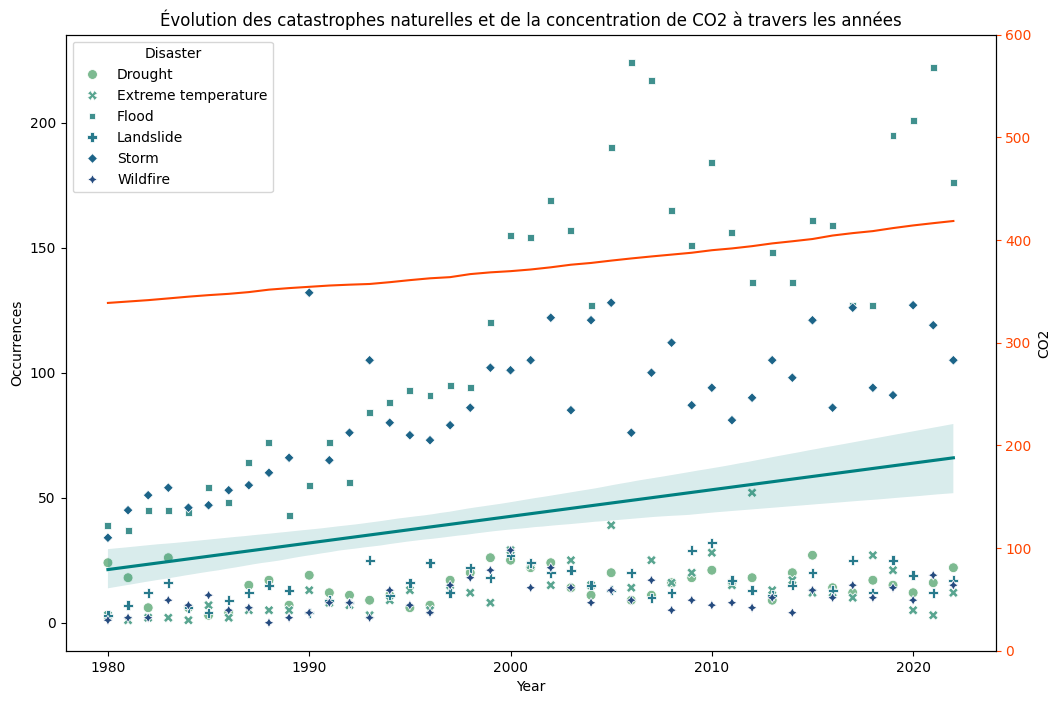

In [107]:
# Convertir 'Year' and 'Scale' en type numérique
df_disasters_world['Year'] = pd.to_numeric(df_disasters_world['Year'])
df_disasters_world['Occurrences'] = pd.to_numeric(df_disasters_world['Occurrences'])

plt.figure(figsize=(12, 8))

# Créer un nuage de point avec différentes couleurs pour chaque indicateur
sns.scatterplot(
    data=df_disasters_world,
    x="Year",
    y="Occurrences",
    hue="Disaster",  # Utilisee la colone 'Disaster' comme nuance
    style="Disaster",  # Utilisee la colone 'Disaster' comme style de point
    palette="crest",
    s=50, # Taille du point
)

# Surimpression d'une seule ligne de régression pour tous les points
sns.regplot(
    data=df_disasters_world,
    x="Year",
    y="Occurrences",
    scatter=False,  # Ne pas afficher le nuage de points 
    color='teal', 
)

# Créer un deuxième axe y pour la ligne de tendance des émissions de CO2
ax2 = plt.gca().twinx()  # Utilise plt.gca() pour obtenir l'axe actuel et le dupliquer

# Créer un graphique en ligne avec les émissions de CO2
sns.lineplot(data=df_co2[:-1], x="Year", y="Value", color='orangered', ax=ax2)

# Paramètres le second axe y 
ax2.set_ylabel('CO2')
ax2.set_ylim(0, 600)
ax2.tick_params(axis='y', colors='orangered')

plt.title('Évolution des catastrophes naturelles et de la concentration de CO2 à travers les années')
plt.show()

### Choix de la catastrophe à afficher

In [108]:
disaster = "Flood"

In [109]:
# Récupérer les données pour un type de catastrophe donné (disaster)
df_disaster = df_disasters[df_disasters['Disaster'] == disaster]

# Trouver les valeurs minimales et maximales de la colonne 'Flood' pour fixer l'échelle de couleur
min_echelle = df_disaster['Occurrences'].min()
max_echelle = df_disaster['Occurrences'].max()

# Créer une carte choroplèthe interactive avec Plotly Express
fig = px.choropleth(df_disaster, locations="ISO3",
                    color="Occurrences",
                    hover_name="Country",
                    animation_frame="Year",
                    color_continuous_scale='deep',
                    title=f'Traversée temporelle des pays impactés par les <i>{disasters_translation[disaster]}</i>',
                    range_color=[min_echelle, max_echelle],
                    width=1000,  # Ajuster la largeur du graphique
                    height=600)  # Ajuster la hauteur du graphique

fig.show()